In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import json
import torch
import torchvision
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
from tqdm import tqdm
from sentence_transformers import SentenceTransformer



In [3]:
# Caption encoder
text_model = SentenceTransformer('all-MiniLM-L6-v2')
caption_dim = 384  # output dim of MiniLM



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [4]:
# -------------------------------
# Dataset with text embeddings
# -------------------------------
class TextToImageDataset(Dataset):
    def __init__(self, image_folder, caption_file, transform=None):
        self.image_folder = image_folder
        self.transform = transform

        with open(caption_file, 'r') as f:
            self.captions = json.load(f)

        self.image_names = list(self.captions.keys())

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        image_path = os.path.join(self.image_folder, image_name)
        image = Image.open(image_path).convert('RGB')
        caption = self.captions[image_name]

        if self.transform:
            image = self.transform(image)

        caption_embedding = torch.tensor(text_model.encode(caption), dtype=torch.float32)
        return image, caption_embedding

# -------------------------------
# Transforms
# -------------------------------
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])



In [5]:
# -------------------------------
# Generator (upsamples to 128x128)
# -------------------------------
class Generator(nn.Module):
    def __init__(self, z_dim, caption_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(z_dim + caption_dim, 1024 * 4 * 4),
            nn.BatchNorm1d(1024 * 4 * 4),
            nn.ReLU(True)
        )
        self.upconv = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, 4, 2, 1),  # 8x8
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1),  # 16x16
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),  # 32x32
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),   # 64x64
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),     # 128x128
            nn.Tanh()
        )

    def forward(self, z, caption_embedding):
        x = torch.cat((z, caption_embedding), dim=1)
        x = self.fc(x)
        x = x.view(-1, 1024, 4, 4)
        return self.upconv(x)

# -------------------------------
# Discriminator with caption conditioning
# -------------------------------
class Discriminator(nn.Module):
    def __init__(self, caption_dim):
        super().__init__()
        self.img_conv = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),   # 64x64
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),  # 32x32
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1),  # 16x16
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1),  # 8x8
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.text_proj = nn.Linear(caption_dim, 512)
        self.final = nn.Sequential(
            nn.Conv2d(1024, 1, 4),  # (512+512)x8x8 → 1x1
        )

    def forward(self, img, caption_embedding):
        img_feat = self.img_conv(img)  # (B, 512, 8, 8)
        text_feat = self.text_proj(caption_embedding).unsqueeze(2).unsqueeze(3)  # (B, 512, 1, 1)
        text_feat = text_feat.repeat(1, 1, 8, 8)  # Broadcast
        x = torch.cat((img_feat, text_feat), dim=1)  # (B, 1024, 8, 8)
        return self.final(x).view(-1, 1)

# -------------------------------
# Training setup
# -------------------------------
z_dim = 100
batch_size = 64
lr = 2e-4
epochs = 500

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = TextToImageDataset("/content/drive/My Drive/flowers/images", "/content/drive/My Drive/flowers/captions_blip.json", transform)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

G = Generator(z_dim, caption_dim).to(device)
D = Discriminator(caption_dim).to(device)

opt_G = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
opt_D = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
criterion = nn.BCEWithLogitsLoss()



In [6]:
# -------------------------------
# Training loop
# -------------------------------
for epoch in range(epochs):
    for real_imgs, captions in tqdm(loader):
        real_imgs = real_imgs.to(device)
        captions = captions.to(device)
        batch_size = real_imgs.size(0)

        # Train Discriminator
        z = torch.randn(batch_size, z_dim).to(device)
        fake_imgs = G(z, captions)

        D_real = D(real_imgs, captions)
        D_fake = D(fake_imgs.detach(), captions)

        real_labels = torch.ones_like(D_real) * 0.9  # Label smoothing
        fake_labels = torch.zeros_like(D_fake)

        loss_D_real = criterion(D_real, real_labels)
        loss_D_fake = criterion(D_fake, fake_labels)
        loss_D = (loss_D_real + loss_D_fake) / 2

        opt_D.zero_grad()
        loss_D.backward()
        opt_D.step()

        # Train Generator
        z = torch.randn(batch_size, z_dim).to(device)
        fake_imgs = G(z, captions)
        D_fake = D(fake_imgs, captions)
        real_labels_fake = torch.ones_like(D_fake)

        loss_G = criterion(D_fake, real_labels_fake)

        opt_G.zero_grad()
        loss_G.backward()
        opt_G.step()

    print(f"[Epoch {epoch}] D Loss: {loss_D.item():.4f}, G Loss: {loss_G.item():.4f}")
    if epoch % 5 == 0:
      # Save generated image grid
      torchvision.utils.save_image(fake_imgs[:16], f"gen_epoch_{epoch}.png", normalize=True, nrow=4)

      # Save models
      torch.save(G.state_dict(), f"generator_epoch_{epoch}.pth")
      torch.save(D.state_dict(), f"discriminator_epoch_{epoch}.pth")
      print(f"✅ Saved generator and discriminator at epoch {epoch}")



100%|██████████| 16/16 [08:14<00:00, 30.91s/it]


[Epoch 0] D Loss: 0.4201, G Loss: 3.3852
✅ Saved generator and discriminator at epoch 0


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 1] D Loss: 0.2608, G Loss: 4.6691


100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


[Epoch 2] D Loss: 0.2742, G Loss: 3.2544


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


[Epoch 3] D Loss: 0.3462, G Loss: 4.1879


100%|██████████| 16/16 [00:17<00:00,  1.08s/it]


[Epoch 4] D Loss: 0.2447, G Loss: 4.9691


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


[Epoch 5] D Loss: 0.1914, G Loss: 5.0637
✅ Saved generator and discriminator at epoch 5


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 6] D Loss: 0.3678, G Loss: 2.5861


100%|██████████| 16/16 [00:17<00:00,  1.07s/it]


[Epoch 7] D Loss: 0.4068, G Loss: 2.6460


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


[Epoch 8] D Loss: 0.9475, G Loss: 2.2667


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 9] D Loss: 0.4082, G Loss: 2.7903


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 10] D Loss: 0.4157, G Loss: 2.2191
✅ Saved generator and discriminator at epoch 10


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


[Epoch 11] D Loss: 0.4080, G Loss: 2.0132


100%|██████████| 16/16 [00:17<00:00,  1.08s/it]


[Epoch 12] D Loss: 0.3881, G Loss: 2.0377


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


[Epoch 13] D Loss: 0.4591, G Loss: 3.0825


100%|██████████| 16/16 [00:17<00:00,  1.08s/it]


[Epoch 14] D Loss: 0.4140, G Loss: 2.0607


100%|██████████| 16/16 [00:17<00:00,  1.08s/it]


[Epoch 15] D Loss: 0.5518, G Loss: 2.8364
✅ Saved generator and discriminator at epoch 15


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


[Epoch 16] D Loss: 0.6574, G Loss: 2.4504


100%|██████████| 16/16 [00:17<00:00,  1.08s/it]


[Epoch 17] D Loss: 0.5277, G Loss: 2.0479


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 18] D Loss: 0.4300, G Loss: 1.7054


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 19] D Loss: 0.5188, G Loss: 3.1138


100%|██████████| 16/16 [00:17<00:00,  1.08s/it]


[Epoch 20] D Loss: 0.4798, G Loss: 1.7836
✅ Saved generator and discriminator at epoch 20


100%|██████████| 16/16 [00:18<00:00,  1.19s/it]


[Epoch 21] D Loss: 0.3825, G Loss: 2.8823


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 22] D Loss: 0.4210, G Loss: 2.3701


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 23] D Loss: 0.5413, G Loss: 2.5967


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


[Epoch 24] D Loss: 0.7909, G Loss: 3.7697


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 25] D Loss: 1.0271, G Loss: 2.0329
✅ Saved generator and discriminator at epoch 25


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


[Epoch 26] D Loss: 0.4493, G Loss: 1.9562


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 27] D Loss: 0.4363, G Loss: 3.6843


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 28] D Loss: 0.4240, G Loss: 5.8154


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


[Epoch 29] D Loss: 0.5390, G Loss: 3.6243


100%|██████████| 16/16 [00:17<00:00,  1.08s/it]


[Epoch 30] D Loss: 0.5234, G Loss: 2.4353
✅ Saved generator and discriminator at epoch 30


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 31] D Loss: 0.4356, G Loss: 2.5453


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


[Epoch 32] D Loss: 0.4315, G Loss: 2.8897


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


[Epoch 33] D Loss: 0.5772, G Loss: 3.9682


100%|██████████| 16/16 [00:18<00:00,  1.17s/it]


[Epoch 34] D Loss: 0.4733, G Loss: 3.2910


100%|██████████| 16/16 [00:18<00:00,  1.17s/it]


[Epoch 35] D Loss: 0.4086, G Loss: 1.8984
✅ Saved generator and discriminator at epoch 35


100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


[Epoch 36] D Loss: 0.5704, G Loss: 1.8728


100%|██████████| 16/16 [00:18<00:00,  1.16s/it]


[Epoch 37] D Loss: 0.4386, G Loss: 1.6461


100%|██████████| 16/16 [00:18<00:00,  1.16s/it]


[Epoch 38] D Loss: 0.4748, G Loss: 2.2863


100%|██████████| 16/16 [00:19<00:00,  1.23s/it]


[Epoch 39] D Loss: 0.4964, G Loss: 2.7436


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


[Epoch 40] D Loss: 0.4559, G Loss: 2.8494
✅ Saved generator and discriminator at epoch 40


100%|██████████| 16/16 [00:18<00:00,  1.16s/it]


[Epoch 41] D Loss: 0.4219, G Loss: 3.2742


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


[Epoch 42] D Loss: 0.5245, G Loss: 2.6509


100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


[Epoch 43] D Loss: 0.4478, G Loss: 2.2020


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


[Epoch 44] D Loss: 0.5565, G Loss: 1.9682


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 45] D Loss: 0.6414, G Loss: 3.0607
✅ Saved generator and discriminator at epoch 45


100%|██████████| 16/16 [00:18<00:00,  1.17s/it]


[Epoch 46] D Loss: 0.3785, G Loss: 2.0948


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 47] D Loss: 0.4764, G Loss: 2.6712


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


[Epoch 48] D Loss: 0.5544, G Loss: 2.0905


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


[Epoch 49] D Loss: 0.5545, G Loss: 1.4515


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 50] D Loss: 0.5086, G Loss: 1.3766
✅ Saved generator and discriminator at epoch 50


100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


[Epoch 51] D Loss: 0.4597, G Loss: 2.3515


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


[Epoch 52] D Loss: 0.4423, G Loss: 1.8674


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 53] D Loss: 0.4382, G Loss: 2.1179


100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


[Epoch 54] D Loss: 0.4117, G Loss: 2.9572


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 55] D Loss: 0.3989, G Loss: 2.4051
✅ Saved generator and discriminator at epoch 55


100%|██████████| 16/16 [00:18<00:00,  1.17s/it]


[Epoch 56] D Loss: 0.6697, G Loss: 1.7260


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


[Epoch 57] D Loss: 0.4805, G Loss: 1.9529


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 58] D Loss: 0.3870, G Loss: 2.7533


100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


[Epoch 59] D Loss: 0.5444, G Loss: 1.8894


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


[Epoch 60] D Loss: 0.5937, G Loss: 1.3142
✅ Saved generator and discriminator at epoch 60


100%|██████████| 16/16 [00:18<00:00,  1.15s/it]


[Epoch 61] D Loss: 0.5758, G Loss: 1.6895


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 62] D Loss: 0.5353, G Loss: 2.0017


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


[Epoch 63] D Loss: 0.4458, G Loss: 1.7706


100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


[Epoch 64] D Loss: 0.4337, G Loss: 2.2840


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 65] D Loss: 0.4766, G Loss: 3.1257
✅ Saved generator and discriminator at epoch 65


100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


[Epoch 66] D Loss: 0.5175, G Loss: 2.1108


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 67] D Loss: 0.4201, G Loss: 2.1722


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 68] D Loss: 0.5179, G Loss: 1.8682


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


[Epoch 69] D Loss: 0.4063, G Loss: 1.8721


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 70] D Loss: 0.4148, G Loss: 2.6880
✅ Saved generator and discriminator at epoch 70


100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


[Epoch 71] D Loss: 0.5108, G Loss: 2.9458


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


[Epoch 72] D Loss: 0.5213, G Loss: 2.1622


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 73] D Loss: 0.3766, G Loss: 2.4032


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


[Epoch 74] D Loss: 0.4822, G Loss: 1.8517


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


[Epoch 75] D Loss: 0.4392, G Loss: 2.5145
✅ Saved generator and discriminator at epoch 75


100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


[Epoch 76] D Loss: 0.4132, G Loss: 3.0830


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


[Epoch 77] D Loss: 0.4555, G Loss: 2.5867


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 78] D Loss: 0.5014, G Loss: 4.2259


100%|██████████| 16/16 [00:18<00:00,  1.15s/it]


[Epoch 79] D Loss: 0.3946, G Loss: 2.7208


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 80] D Loss: 0.4439, G Loss: 2.3504
✅ Saved generator and discriminator at epoch 80


100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


[Epoch 81] D Loss: 0.5662, G Loss: 1.4739


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


[Epoch 82] D Loss: 0.5133, G Loss: 3.7754


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 83] D Loss: 0.5210, G Loss: 2.0576


100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


[Epoch 84] D Loss: 0.4494, G Loss: 2.2077


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


[Epoch 85] D Loss: 0.5542, G Loss: 1.6863
✅ Saved generator and discriminator at epoch 85


100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


[Epoch 86] D Loss: 0.4421, G Loss: 2.0829


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


[Epoch 87] D Loss: 0.5820, G Loss: 3.0950


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 88] D Loss: 0.4442, G Loss: 2.4032


100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


[Epoch 89] D Loss: 0.5553, G Loss: 3.6131


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


[Epoch 90] D Loss: 0.4297, G Loss: 2.1714
✅ Saved generator and discriminator at epoch 90


100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


[Epoch 91] D Loss: 0.5620, G Loss: 3.1398


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


[Epoch 92] D Loss: 0.6886, G Loss: 4.4418


100%|██████████| 16/16 [00:18<00:00,  1.15s/it]


[Epoch 93] D Loss: 0.5319, G Loss: 1.6911


100%|██████████| 16/16 [00:18<00:00,  1.15s/it]


[Epoch 94] D Loss: 0.5327, G Loss: 1.5063


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


[Epoch 95] D Loss: 0.6452, G Loss: 1.0575
✅ Saved generator and discriminator at epoch 95


100%|██████████| 16/16 [00:18<00:00,  1.15s/it]


[Epoch 96] D Loss: 0.3941, G Loss: 2.1010


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


[Epoch 97] D Loss: 0.5080, G Loss: 1.5388


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 98] D Loss: 0.4212, G Loss: 2.4882


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


[Epoch 99] D Loss: 0.4707, G Loss: 2.6239


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 100] D Loss: 0.5019, G Loss: 1.9793
✅ Saved generator and discriminator at epoch 100


100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


[Epoch 101] D Loss: 0.4538, G Loss: 1.6703


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


[Epoch 102] D Loss: 0.4539, G Loss: 1.9113


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 103] D Loss: 0.4817, G Loss: 3.1569


100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


[Epoch 104] D Loss: 0.5904, G Loss: 3.7223


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 105] D Loss: 0.4499, G Loss: 2.3729
✅ Saved generator and discriminator at epoch 105


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


[Epoch 106] D Loss: 0.5004, G Loss: 3.6754


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


[Epoch 107] D Loss: 0.4259, G Loss: 2.7739


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 108] D Loss: 0.4619, G Loss: 2.4838


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


[Epoch 109] D Loss: 0.4091, G Loss: 2.8231


100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


[Epoch 110] D Loss: 0.4377, G Loss: 2.4869
✅ Saved generator and discriminator at epoch 110


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


[Epoch 111] D Loss: 0.4407, G Loss: 3.5440


100%|██████████| 16/16 [00:18<00:00,  1.16s/it]


[Epoch 112] D Loss: 0.3988, G Loss: 2.7255


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


[Epoch 113] D Loss: 0.3842, G Loss: 2.6962


100%|██████████| 16/16 [00:18<00:00,  1.15s/it]


[Epoch 114] D Loss: 0.3853, G Loss: 2.5347


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 115] D Loss: 0.7488, G Loss: 1.3570
✅ Saved generator and discriminator at epoch 115


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


[Epoch 116] D Loss: 0.4312, G Loss: 2.0425


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


[Epoch 117] D Loss: 0.4025, G Loss: 2.2987


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 118] D Loss: 0.4030, G Loss: 3.1024


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


[Epoch 119] D Loss: 0.3401, G Loss: 2.6456


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 120] D Loss: 0.4476, G Loss: 2.0979
✅ Saved generator and discriminator at epoch 120


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


[Epoch 121] D Loss: 0.4533, G Loss: 3.7038


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


[Epoch 122] D Loss: 0.4214, G Loss: 2.0402


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 123] D Loss: 0.4208, G Loss: 3.3176


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


[Epoch 124] D Loss: 0.5792, G Loss: 1.2715


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


[Epoch 125] D Loss: 0.4347, G Loss: 2.0288
✅ Saved generator and discriminator at epoch 125


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


[Epoch 126] D Loss: 0.3662, G Loss: 2.4455


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


[Epoch 127] D Loss: 0.5584, G Loss: 1.4970


100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


[Epoch 128] D Loss: 0.4105, G Loss: 2.6380


100%|██████████| 16/16 [00:18<00:00,  1.15s/it]


[Epoch 129] D Loss: 0.3897, G Loss: 2.4933


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 130] D Loss: 0.4007, G Loss: 3.3853
✅ Saved generator and discriminator at epoch 130


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 131] D Loss: 0.4549, G Loss: 1.7485


100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


[Epoch 132] D Loss: 0.4435, G Loss: 1.8019


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 133] D Loss: 0.3467, G Loss: 2.6888


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


[Epoch 134] D Loss: 0.3965, G Loss: 3.8620


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


[Epoch 135] D Loss: 0.4084, G Loss: 1.9447
✅ Saved generator and discriminator at epoch 135


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


[Epoch 136] D Loss: 0.4520, G Loss: 1.7157


100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


[Epoch 137] D Loss: 0.3409, G Loss: 2.2476


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 138] D Loss: 0.3918, G Loss: 2.2749


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


[Epoch 139] D Loss: 0.4255, G Loss: 3.4754


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


[Epoch 140] D Loss: 0.5028, G Loss: 0.9985
✅ Saved generator and discriminator at epoch 140


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 141] D Loss: 0.3930, G Loss: 2.4080


100%|██████████| 16/16 [00:18<00:00,  1.15s/it]


[Epoch 142] D Loss: 0.4484, G Loss: 3.9382


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 143] D Loss: 0.4254, G Loss: 3.0710


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


[Epoch 144] D Loss: 0.3616, G Loss: 2.2293


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


[Epoch 145] D Loss: 1.3789, G Loss: 1.5534
✅ Saved generator and discriminator at epoch 145


100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


[Epoch 146] D Loss: 0.4196, G Loss: 2.2086


100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


[Epoch 147] D Loss: 0.5566, G Loss: 3.9376


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 148] D Loss: 0.4061, G Loss: 4.0065


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


[Epoch 149] D Loss: 0.4499, G Loss: 2.8896


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


[Epoch 150] D Loss: 0.3984, G Loss: 2.2286
✅ Saved generator and discriminator at epoch 150


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


[Epoch 151] D Loss: 0.3558, G Loss: 3.1162


100%|██████████| 16/16 [00:18<00:00,  1.15s/it]


[Epoch 152] D Loss: 0.4377, G Loss: 1.5733


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


[Epoch 153] D Loss: 0.3959, G Loss: 1.8471


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


[Epoch 154] D Loss: 0.3664, G Loss: 2.6777


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


[Epoch 155] D Loss: 0.3776, G Loss: 2.2020
✅ Saved generator and discriminator at epoch 155


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


[Epoch 156] D Loss: 0.3327, G Loss: 3.3972


100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


[Epoch 157] D Loss: 0.4878, G Loss: 1.8674


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 158] D Loss: 0.4891, G Loss: 4.9154


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 159] D Loss: 0.4835, G Loss: 1.3667


100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


[Epoch 160] D Loss: 0.4480, G Loss: 1.5693
✅ Saved generator and discriminator at epoch 160


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 161] D Loss: 0.5527, G Loss: 4.5702


100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


[Epoch 162] D Loss: 0.3522, G Loss: 3.0940


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


[Epoch 163] D Loss: 0.3762, G Loss: 2.5982


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


[Epoch 164] D Loss: 0.4788, G Loss: 1.9504


100%|██████████| 16/16 [00:18<00:00,  1.16s/it]


[Epoch 165] D Loss: 0.6959, G Loss: 5.1731
✅ Saved generator and discriminator at epoch 165


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


[Epoch 166] D Loss: 0.3843, G Loss: 2.1427


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


[Epoch 167] D Loss: 0.3681, G Loss: 2.3132


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 168] D Loss: 0.5808, G Loss: 4.3063


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 169] D Loss: 0.4002, G Loss: 1.7636


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


[Epoch 170] D Loss: 0.4153, G Loss: 1.7004
✅ Saved generator and discriminator at epoch 170


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


[Epoch 171] D Loss: 0.7548, G Loss: 1.3337


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


[Epoch 172] D Loss: 0.4023, G Loss: 2.1247


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


[Epoch 173] D Loss: 0.4428, G Loss: 1.3980


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 174] D Loss: 0.3706, G Loss: 2.8027


100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


[Epoch 175] D Loss: 0.3974, G Loss: 2.1882
✅ Saved generator and discriminator at epoch 175


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


[Epoch 176] D Loss: 0.4226, G Loss: 2.8731


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 177] D Loss: 0.5355, G Loss: 3.2672


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


[Epoch 178] D Loss: 0.4418, G Loss: 3.7352


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 179] D Loss: 0.5237, G Loss: 1.2169


100%|██████████| 16/16 [00:18<00:00,  1.15s/it]


[Epoch 180] D Loss: 0.3355, G Loss: 3.1737
✅ Saved generator and discriminator at epoch 180


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


[Epoch 181] D Loss: 0.3679, G Loss: 2.6097


100%|██████████| 16/16 [00:18<00:00,  1.15s/it]


[Epoch 182] D Loss: 0.4669, G Loss: 1.5536


100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


[Epoch 183] D Loss: 0.4273, G Loss: 1.9493


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 184] D Loss: 0.4448, G Loss: 3.1532


100%|██████████| 16/16 [00:18<00:00,  1.15s/it]


[Epoch 185] D Loss: 0.3488, G Loss: 2.5203
✅ Saved generator and discriminator at epoch 185


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


[Epoch 186] D Loss: 0.3955, G Loss: 1.6352


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


[Epoch 187] D Loss: 0.4009, G Loss: 2.7227


100%|██████████| 16/16 [00:18<00:00,  1.15s/it]


[Epoch 188] D Loss: 0.3676, G Loss: 2.2675


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


[Epoch 189] D Loss: 0.3682, G Loss: 2.7672


100%|██████████| 16/16 [00:18<00:00,  1.15s/it]


[Epoch 190] D Loss: 0.3921, G Loss: 2.3022
✅ Saved generator and discriminator at epoch 190


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


[Epoch 191] D Loss: 0.5056, G Loss: 1.5540


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


[Epoch 192] D Loss: 0.7034, G Loss: 1.5963


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


[Epoch 193] D Loss: 0.4285, G Loss: 1.9121


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 194] D Loss: 0.6510, G Loss: 4.9935


100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


[Epoch 195] D Loss: 0.3740, G Loss: 4.0694
✅ Saved generator and discriminator at epoch 195


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 196] D Loss: 0.3655, G Loss: 2.1730


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


[Epoch 197] D Loss: 0.3575, G Loss: 2.5022


100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


[Epoch 198] D Loss: 0.4782, G Loss: 3.8652


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 199] D Loss: 0.3731, G Loss: 3.1209


100%|██████████| 16/16 [00:18<00:00,  1.19s/it]


[Epoch 200] D Loss: 0.4589, G Loss: 4.2028
✅ Saved generator and discriminator at epoch 200


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


[Epoch 201] D Loss: 0.5380, G Loss: 3.4866


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


[Epoch 202] D Loss: 0.4653, G Loss: 3.9291


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


[Epoch 203] D Loss: 0.4989, G Loss: 1.6566


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 204] D Loss: 0.3952, G Loss: 2.2064


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


[Epoch 205] D Loss: 0.4681, G Loss: 3.5894
✅ Saved generator and discriminator at epoch 205


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


[Epoch 206] D Loss: 0.3602, G Loss: 3.6993


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


[Epoch 207] D Loss: 0.4329, G Loss: 2.6851


100%|██████████| 16/16 [00:18<00:00,  1.15s/it]


[Epoch 208] D Loss: 0.3925, G Loss: 1.9255


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


[Epoch 209] D Loss: 0.3943, G Loss: 3.1515


100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


[Epoch 210] D Loss: 0.4856, G Loss: 3.7675
✅ Saved generator and discriminator at epoch 210


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


[Epoch 211] D Loss: 0.4146, G Loss: 1.8980


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


[Epoch 212] D Loss: 0.3683, G Loss: 2.6731


100%|██████████| 16/16 [00:18<00:00,  1.15s/it]


[Epoch 213] D Loss: 0.3594, G Loss: 2.6056


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


[Epoch 214] D Loss: 0.5762, G Loss: 5.4697


100%|██████████| 16/16 [00:18<00:00,  1.15s/it]


[Epoch 215] D Loss: 0.4440, G Loss: 1.9230
✅ Saved generator and discriminator at epoch 215


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


[Epoch 216] D Loss: 0.3427, G Loss: 2.3072


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 217] D Loss: 0.4432, G Loss: 1.7080


100%|██████████| 16/16 [00:18<00:00,  1.18s/it]


[Epoch 218] D Loss: 0.6464, G Loss: 5.6400


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 219] D Loss: 0.3254, G Loss: 3.5771


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


[Epoch 220] D Loss: 0.3990, G Loss: 3.4544
✅ Saved generator and discriminator at epoch 220


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


[Epoch 221] D Loss: 0.6097, G Loss: 1.1423


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 222] D Loss: 0.4019, G Loss: 3.2566


100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


[Epoch 223] D Loss: 0.3709, G Loss: 2.4856


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


[Epoch 224] D Loss: 0.7656, G Loss: 1.8117


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


[Epoch 225] D Loss: 0.3590, G Loss: 2.4391
✅ Saved generator and discriminator at epoch 225


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


[Epoch 226] D Loss: 0.3843, G Loss: 2.1979


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 227] D Loss: 0.3599, G Loss: 1.8870


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


[Epoch 228] D Loss: 0.4206, G Loss: 2.9403


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 229] D Loss: 0.3728, G Loss: 2.3434


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 230] D Loss: 0.3952, G Loss: 2.7172
✅ Saved generator and discriminator at epoch 230


100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


[Epoch 231] D Loss: 0.8038, G Loss: 4.7102


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 232] D Loss: 0.3137, G Loss: 3.3195


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


[Epoch 233] D Loss: 0.4271, G Loss: 3.0185


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 234] D Loss: 0.4020, G Loss: 1.9609


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 235] D Loss: 0.4266, G Loss: 3.2605
✅ Saved generator and discriminator at epoch 235


100%|██████████| 16/16 [00:18<00:00,  1.18s/it]


[Epoch 236] D Loss: 0.3222, G Loss: 2.8756


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 237] D Loss: 0.3511, G Loss: 2.4656


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


[Epoch 238] D Loss: 0.4037, G Loss: 2.3001


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 239] D Loss: 0.3668, G Loss: 2.0579


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 240] D Loss: 0.3817, G Loss: 2.7561
✅ Saved generator and discriminator at epoch 240


100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


[Epoch 241] D Loss: 0.4404, G Loss: 3.0891


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 242] D Loss: 0.3574, G Loss: 1.8275


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 243] D Loss: 0.3790, G Loss: 1.7247


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


[Epoch 244] D Loss: 0.4528, G Loss: 1.8397


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 245] D Loss: 0.3241, G Loss: 1.9832
✅ Saved generator and discriminator at epoch 245


100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


[Epoch 246] D Loss: 0.3791, G Loss: 2.7152


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 247] D Loss: 0.3185, G Loss: 2.9811


100%|██████████| 16/16 [00:17<00:00,  1.08s/it]


[Epoch 248] D Loss: 0.3797, G Loss: 2.7495


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


[Epoch 249] D Loss: 0.3884, G Loss: 2.1866


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 250] D Loss: 0.5216, G Loss: 5.3988
✅ Saved generator and discriminator at epoch 250


100%|██████████| 16/16 [00:18<00:00,  1.15s/it]


[Epoch 251] D Loss: 0.4023, G Loss: 2.3486


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 252] D Loss: 0.3585, G Loss: 2.3752


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 253] D Loss: 0.3081, G Loss: 3.3042


100%|██████████| 16/16 [00:18<00:00,  1.16s/it]


[Epoch 254] D Loss: 0.3902, G Loss: 3.9862


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 255] D Loss: 0.4870, G Loss: 2.7797
✅ Saved generator and discriminator at epoch 255


100%|██████████| 16/16 [00:18<00:00,  1.15s/it]


[Epoch 256] D Loss: 0.3576, G Loss: 2.2880


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 257] D Loss: 0.3908, G Loss: 2.1736


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 258] D Loss: 0.3457, G Loss: 3.2507


100%|██████████| 16/16 [00:18<00:00,  1.15s/it]


[Epoch 259] D Loss: 0.3651, G Loss: 2.9351


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 260] D Loss: 0.4526, G Loss: 1.8928
✅ Saved generator and discriminator at epoch 260


100%|██████████| 16/16 [00:18<00:00,  1.16s/it]


[Epoch 261] D Loss: 0.3333, G Loss: 3.4913


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


[Epoch 262] D Loss: 0.5917, G Loss: 5.0809


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


[Epoch 263] D Loss: 0.4037, G Loss: 3.2762


100%|██████████| 16/16 [00:18<00:00,  1.15s/it]


[Epoch 264] D Loss: 0.3033, G Loss: 2.8064


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


[Epoch 265] D Loss: 0.3454, G Loss: 1.8113
✅ Saved generator and discriminator at epoch 265


100%|██████████| 16/16 [00:18<00:00,  1.15s/it]


[Epoch 266] D Loss: 0.3717, G Loss: 2.8135


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


[Epoch 267] D Loss: 0.3637, G Loss: 2.4595


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


[Epoch 268] D Loss: 0.3932, G Loss: 3.1626


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


[Epoch 269] D Loss: 0.3570, G Loss: 1.7130


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 270] D Loss: 0.3740, G Loss: 2.6478
✅ Saved generator and discriminator at epoch 270


100%|██████████| 16/16 [00:19<00:00,  1.19s/it]


[Epoch 271] D Loss: 0.3510, G Loss: 2.3076


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


[Epoch 272] D Loss: 0.3745, G Loss: 2.5889


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 273] D Loss: 0.3106, G Loss: 2.6280


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


[Epoch 274] D Loss: 0.4507, G Loss: 4.0094


100%|██████████| 16/16 [00:17<00:00,  1.08s/it]


[Epoch 275] D Loss: 0.3402, G Loss: 3.3389
✅ Saved generator and discriminator at epoch 275


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


[Epoch 276] D Loss: 0.3886, G Loss: 4.9554


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


[Epoch 277] D Loss: 0.3998, G Loss: 2.3175


100%|██████████| 16/16 [00:17<00:00,  1.08s/it]


[Epoch 278] D Loss: 0.3540, G Loss: 3.0593


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


[Epoch 279] D Loss: 0.3898, G Loss: 1.4575


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 280] D Loss: 0.3366, G Loss: 3.1809
✅ Saved generator and discriminator at epoch 280


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


[Epoch 281] D Loss: 0.4619, G Loss: 4.2734


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


[Epoch 282] D Loss: 0.3876, G Loss: 2.1483


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 283] D Loss: 0.3423, G Loss: 2.2380


100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


[Epoch 284] D Loss: 0.3810, G Loss: 2.2656


100%|██████████| 16/16 [00:17<00:00,  1.08s/it]


[Epoch 285] D Loss: 0.4333, G Loss: 1.2828
✅ Saved generator and discriminator at epoch 285


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 286] D Loss: 0.3863, G Loss: 3.5084


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


[Epoch 287] D Loss: 0.3494, G Loss: 2.1610


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 288] D Loss: 0.3006, G Loss: 2.4271


100%|██████████| 16/16 [00:18<00:00,  1.17s/it]


[Epoch 289] D Loss: 0.4336, G Loss: 2.4853


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


[Epoch 290] D Loss: 0.3740, G Loss: 4.0206
✅ Saved generator and discriminator at epoch 290


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 291] D Loss: 0.3398, G Loss: 2.7368


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


[Epoch 292] D Loss: 0.7104, G Loss: 5.2053


100%|██████████| 16/16 [00:17<00:00,  1.08s/it]


[Epoch 293] D Loss: 0.3486, G Loss: 3.5605


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 294] D Loss: 0.5783, G Loss: 1.4424


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


[Epoch 295] D Loss: 0.3701, G Loss: 1.8819
✅ Saved generator and discriminator at epoch 295


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 296] D Loss: 0.3415, G Loss: 2.7392


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


[Epoch 297] D Loss: 0.3912, G Loss: 2.3604


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 298] D Loss: 0.5220, G Loss: 1.7199


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 299] D Loss: 0.3110, G Loss: 3.2201


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


[Epoch 300] D Loss: 0.3853, G Loss: 3.2711
✅ Saved generator and discriminator at epoch 300


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 301] D Loss: 0.3820, G Loss: 3.3724


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 302] D Loss: 0.3358, G Loss: 3.6777


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 303] D Loss: 0.3723, G Loss: 2.9966


100%|██████████| 16/16 [00:17<00:00,  1.08s/it]


[Epoch 304] D Loss: 0.3242, G Loss: 3.5156


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


[Epoch 305] D Loss: 0.4223, G Loss: 3.3655
✅ Saved generator and discriminator at epoch 305


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


[Epoch 306] D Loss: 0.2823, G Loss: 3.1240


100%|██████████| 16/16 [00:18<00:00,  1.15s/it]


[Epoch 307] D Loss: 0.5307, G Loss: 1.3437


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


[Epoch 308] D Loss: 0.4280, G Loss: 1.8043


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 309] D Loss: 0.3707, G Loss: 2.1609


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 310] D Loss: 0.3980, G Loss: 2.9049
✅ Saved generator and discriminator at epoch 310


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


[Epoch 311] D Loss: 0.5653, G Loss: 5.5827


100%|██████████| 16/16 [00:17<00:00,  1.08s/it]


[Epoch 312] D Loss: 0.3218, G Loss: 4.0114


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


[Epoch 313] D Loss: 0.3577, G Loss: 3.3939


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 314] D Loss: 0.3777, G Loss: 3.1471


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 315] D Loss: 0.3905, G Loss: 3.4310
✅ Saved generator and discriminator at epoch 315


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


[Epoch 316] D Loss: 0.3120, G Loss: 2.7574


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 317] D Loss: 0.3025, G Loss: 2.9390


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


[Epoch 318] D Loss: 0.3314, G Loss: 3.1583


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 319] D Loss: 0.9010, G Loss: 1.7859


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 320] D Loss: 0.4681, G Loss: 1.7884
✅ Saved generator and discriminator at epoch 320


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


[Epoch 321] D Loss: 0.4113, G Loss: 3.1168


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 322] D Loss: 0.3717, G Loss: 2.1525


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 323] D Loss: 0.4181, G Loss: 2.4738


100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


[Epoch 324] D Loss: 0.3935, G Loss: 3.4456


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


[Epoch 325] D Loss: 0.3497, G Loss: 2.7942
✅ Saved generator and discriminator at epoch 325


100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


[Epoch 326] D Loss: 0.4149, G Loss: 1.6256


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 327] D Loss: 0.3517, G Loss: 2.2979


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 328] D Loss: 0.4044, G Loss: 1.7773


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


[Epoch 329] D Loss: 0.4365, G Loss: 2.1824


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 330] D Loss: 0.3325, G Loss: 2.7814
✅ Saved generator and discriminator at epoch 330


100%|██████████| 16/16 [00:18<00:00,  1.15s/it]


[Epoch 331] D Loss: 0.3376, G Loss: 2.6328


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 332] D Loss: 0.3714, G Loss: 2.3060


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 333] D Loss: 0.3834, G Loss: 2.0842


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


[Epoch 334] D Loss: 0.3342, G Loss: 3.2930


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 335] D Loss: 0.3227, G Loss: 2.2048
✅ Saved generator and discriminator at epoch 335


100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


[Epoch 336] D Loss: 0.3693, G Loss: 2.3477


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


[Epoch 337] D Loss: 0.4187, G Loss: 3.6209


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 338] D Loss: 0.4714, G Loss: 3.8216


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


[Epoch 339] D Loss: 0.3158, G Loss: 2.3644


100%|██████████| 16/16 [00:17<00:00,  1.08s/it]


[Epoch 340] D Loss: 0.3029, G Loss: 3.4686
✅ Saved generator and discriminator at epoch 340


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


[Epoch 341] D Loss: 0.5337, G Loss: 1.3658


100%|██████████| 16/16 [00:18<00:00,  1.16s/it]


[Epoch 342] D Loss: 0.3957, G Loss: 3.3795


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 343] D Loss: 0.3054, G Loss: 3.5742


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


[Epoch 344] D Loss: 0.3933, G Loss: 1.9267


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 345] D Loss: 0.3569, G Loss: 2.3274
✅ Saved generator and discriminator at epoch 345


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


[Epoch 346] D Loss: 0.3370, G Loss: 2.2435


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


[Epoch 347] D Loss: 0.4331, G Loss: 1.0044


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 348] D Loss: 0.6976, G Loss: 1.5499


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


[Epoch 349] D Loss: 0.3475, G Loss: 3.2387


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 350] D Loss: 0.4335, G Loss: 1.9967
✅ Saved generator and discriminator at epoch 350


100%|██████████| 16/16 [00:17<00:00,  1.08s/it]


[Epoch 351] D Loss: 0.3033, G Loss: 3.2560


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


[Epoch 352] D Loss: 0.3150, G Loss: 2.8512


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 353] D Loss: 0.3618, G Loss: 1.8490


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 354] D Loss: 0.4992, G Loss: 1.9482


100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


[Epoch 355] D Loss: 0.3747, G Loss: 4.3773
✅ Saved generator and discriminator at epoch 355


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


[Epoch 356] D Loss: 0.5247, G Loss: 0.9133


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


[Epoch 357] D Loss: 0.3364, G Loss: 2.9533


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 358] D Loss: 0.3308, G Loss: 2.8687


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


[Epoch 359] D Loss: 0.3809, G Loss: 2.1911


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


[Epoch 360] D Loss: 0.3648, G Loss: 4.2028
✅ Saved generator and discriminator at epoch 360


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 361] D Loss: 0.5079, G Loss: 1.3941


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


[Epoch 362] D Loss: 0.3212, G Loss: 2.4617


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 363] D Loss: 0.3154, G Loss: 2.6592


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 364] D Loss: 0.3252, G Loss: 2.0748


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


[Epoch 365] D Loss: 0.3305, G Loss: 1.7535
✅ Saved generator and discriminator at epoch 365


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 366] D Loss: 0.4506, G Loss: 2.1220


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


[Epoch 367] D Loss: 0.3541, G Loss: 3.0298


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 368] D Loss: 0.3812, G Loss: 3.4917


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 369] D Loss: 0.2968, G Loss: 3.0854


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


[Epoch 370] D Loss: 0.3393, G Loss: 1.9809
✅ Saved generator and discriminator at epoch 370


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


[Epoch 371] D Loss: 0.3348, G Loss: 2.4719


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 372] D Loss: 0.3612, G Loss: 4.2665


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


[Epoch 373] D Loss: 0.3495, G Loss: 2.0388


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 374] D Loss: 0.5310, G Loss: 1.7575


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


[Epoch 375] D Loss: 0.6393, G Loss: 5.0584
✅ Saved generator and discriminator at epoch 375


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


[Epoch 376] D Loss: 0.3786, G Loss: 3.4854


100%|██████████| 16/16 [00:18<00:00,  1.15s/it]


[Epoch 377] D Loss: 0.3453, G Loss: 1.7015


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


[Epoch 378] D Loss: 0.4417, G Loss: 1.3007


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


[Epoch 379] D Loss: 0.3947, G Loss: 2.9508


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


[Epoch 380] D Loss: 0.4903, G Loss: 1.7979
✅ Saved generator and discriminator at epoch 380


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


[Epoch 381] D Loss: 0.3675, G Loss: 1.9488


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 382] D Loss: 0.3211, G Loss: 2.9919


100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


[Epoch 383] D Loss: 0.3066, G Loss: 3.6966


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


[Epoch 384] D Loss: 0.3806, G Loss: 4.0405


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


[Epoch 385] D Loss: 0.3966, G Loss: 3.4173
✅ Saved generator and discriminator at epoch 385


100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


[Epoch 386] D Loss: 0.3448, G Loss: 1.4526


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 387] D Loss: 0.4400, G Loss: 4.8375


100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


[Epoch 388] D Loss: 0.3557, G Loss: 2.5986


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


[Epoch 389] D Loss: 0.3441, G Loss: 3.0707


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


[Epoch 390] D Loss: 0.2858, G Loss: 3.1847
✅ Saved generator and discriminator at epoch 390


100%|██████████| 16/16 [00:18<00:00,  1.19s/it]


[Epoch 391] D Loss: 0.3119, G Loss: 2.5300


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


[Epoch 392] D Loss: 0.3006, G Loss: 2.8459


100%|██████████| 16/16 [00:18<00:00,  1.16s/it]


[Epoch 393] D Loss: 0.3080, G Loss: 3.8830


100%|██████████| 16/16 [00:18<00:00,  1.16s/it]


[Epoch 394] D Loss: 0.3275, G Loss: 3.1343


100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


[Epoch 395] D Loss: 0.3217, G Loss: 2.0659
✅ Saved generator and discriminator at epoch 395


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 396] D Loss: 0.2814, G Loss: 3.4263


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


[Epoch 397] D Loss: 0.4357, G Loss: 4.5466


100%|██████████| 16/16 [00:18<00:00,  1.17s/it]


[Epoch 398] D Loss: 0.3561, G Loss: 2.5707


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


[Epoch 399] D Loss: 0.2941, G Loss: 3.8511


100%|██████████| 16/16 [00:18<00:00,  1.15s/it]


[Epoch 400] D Loss: 0.2886, G Loss: 2.9989
✅ Saved generator and discriminator at epoch 400


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 401] D Loss: 0.3157, G Loss: 2.7675


100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


[Epoch 402] D Loss: 0.3084, G Loss: 3.7567


100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


[Epoch 403] D Loss: 0.4606, G Loss: 1.5604


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


[Epoch 404] D Loss: 0.2820, G Loss: 2.7179


100%|██████████| 16/16 [00:18<00:00,  1.18s/it]


[Epoch 405] D Loss: 0.2974, G Loss: 2.7709
✅ Saved generator and discriminator at epoch 405


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


[Epoch 406] D Loss: 0.2959, G Loss: 2.1783


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


[Epoch 407] D Loss: 0.3547, G Loss: 1.8705


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


[Epoch 408] D Loss: 0.3016, G Loss: 3.3475


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 409] D Loss: 0.2612, G Loss: 3.4255


100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


[Epoch 410] D Loss: 0.2969, G Loss: 3.6736
✅ Saved generator and discriminator at epoch 410


100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


[Epoch 411] D Loss: 0.2828, G Loss: 3.0059


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


[Epoch 412] D Loss: 0.3421, G Loss: 2.3502


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


[Epoch 413] D Loss: 0.3489, G Loss: 4.0811


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 414] D Loss: 0.3870, G Loss: 1.2702


100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


[Epoch 415] D Loss: 0.2934, G Loss: 3.5396
✅ Saved generator and discriminator at epoch 415


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


[Epoch 416] D Loss: 0.3116, G Loss: 3.8201


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


[Epoch 417] D Loss: 0.2929, G Loss: 2.6869


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


[Epoch 418] D Loss: 0.4743, G Loss: 1.3498


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 419] D Loss: 0.3050, G Loss: 2.7749


100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


[Epoch 420] D Loss: 0.4523, G Loss: 2.0360
✅ Saved generator and discriminator at epoch 420


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


[Epoch 421] D Loss: 0.3064, G Loss: 3.0359


100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


[Epoch 422] D Loss: 0.4096, G Loss: 2.8623


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 423] D Loss: 0.2802, G Loss: 2.7287


100%|██████████| 16/16 [00:17<00:00,  1.08s/it]


[Epoch 424] D Loss: 0.2948, G Loss: 2.4471


100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


[Epoch 425] D Loss: 0.2908, G Loss: 2.9219
✅ Saved generator and discriminator at epoch 425


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


[Epoch 426] D Loss: 0.3449, G Loss: 2.2515


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


[Epoch 427] D Loss: 0.3891, G Loss: 4.4978


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 428] D Loss: 0.8926, G Loss: 2.2191


100%|██████████| 16/16 [00:17<00:00,  1.08s/it]


[Epoch 429] D Loss: 0.3432, G Loss: 2.5893


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


[Epoch 430] D Loss: 0.3338, G Loss: 3.0991
✅ Saved generator and discriminator at epoch 430


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 431] D Loss: 0.3686, G Loss: 2.0119


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


[Epoch 432] D Loss: 0.4151, G Loss: 2.1917


100%|██████████| 16/16 [00:18<00:00,  1.18s/it]


[Epoch 433] D Loss: 0.3543, G Loss: 4.1800


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


[Epoch 434] D Loss: 0.3379, G Loss: 2.8907


100%|██████████| 16/16 [00:19<00:00,  1.19s/it]


[Epoch 435] D Loss: 0.3312, G Loss: 3.1463
✅ Saved generator and discriminator at epoch 435


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


[Epoch 436] D Loss: 0.2856, G Loss: 2.6698


100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


[Epoch 437] D Loss: 0.3385, G Loss: 4.2505


100%|██████████| 16/16 [00:18<00:00,  1.17s/it]


[Epoch 438] D Loss: 0.3636, G Loss: 2.2045


100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


[Epoch 439] D Loss: 0.3378, G Loss: 4.5689


100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


[Epoch 440] D Loss: 0.2681, G Loss: 2.8473
✅ Saved generator and discriminator at epoch 440


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


[Epoch 441] D Loss: 0.3105, G Loss: 3.4307


100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


[Epoch 442] D Loss: 0.2921, G Loss: 3.7329


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 443] D Loss: 0.3810, G Loss: 3.6091


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 444] D Loss: 0.3137, G Loss: 3.1070


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


[Epoch 445] D Loss: 0.2969, G Loss: 3.4213
✅ Saved generator and discriminator at epoch 445


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 446] D Loss: 0.3074, G Loss: 3.6308


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


[Epoch 447] D Loss: 0.3359, G Loss: 2.4330


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 448] D Loss: 0.3567, G Loss: 3.1938


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 449] D Loss: 0.3154, G Loss: 2.3872


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


[Epoch 450] D Loss: 0.2587, G Loss: 3.3393
✅ Saved generator and discriminator at epoch 450


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 451] D Loss: 0.3461, G Loss: 3.4151


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 452] D Loss: 0.2799, G Loss: 3.2571


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


[Epoch 453] D Loss: 0.2775, G Loss: 4.2158


100%|██████████| 16/16 [00:17<00:00,  1.08s/it]


[Epoch 454] D Loss: 0.3261, G Loss: 4.0510


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


[Epoch 455] D Loss: 0.3572, G Loss: 2.2403
✅ Saved generator and discriminator at epoch 455


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


[Epoch 456] D Loss: 0.2926, G Loss: 2.5835


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 457] D Loss: 0.2582, G Loss: 4.1035


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


[Epoch 458] D Loss: 1.0918, G Loss: 5.5551


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 459] D Loss: 0.2934, G Loss: 2.9486


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


[Epoch 460] D Loss: 0.3327, G Loss: 3.7050
✅ Saved generator and discriminator at epoch 460


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


[Epoch 461] D Loss: 0.3365, G Loss: 2.0528


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 462] D Loss: 0.2949, G Loss: 2.8430


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


[Epoch 463] D Loss: 0.2673, G Loss: 3.4617


100%|██████████| 16/16 [00:17<00:00,  1.08s/it]


[Epoch 464] D Loss: 0.5097, G Loss: 4.4521


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 465] D Loss: 0.2843, G Loss: 3.4722
✅ Saved generator and discriminator at epoch 465


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


[Epoch 466] D Loss: 0.2757, G Loss: 2.6812


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 467] D Loss: 0.3272, G Loss: 1.7914


100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


[Epoch 468] D Loss: 0.3256, G Loss: 2.4738


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


[Epoch 469] D Loss: 0.2882, G Loss: 3.0745


100%|██████████| 16/16 [00:18<00:00,  1.15s/it]


[Epoch 470] D Loss: 0.2745, G Loss: 2.5780
✅ Saved generator and discriminator at epoch 470


100%|██████████| 16/16 [00:18<00:00,  1.15s/it]


[Epoch 471] D Loss: 0.2968, G Loss: 2.9431


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


[Epoch 472] D Loss: 0.2770, G Loss: 3.1114


100%|██████████| 16/16 [00:18<00:00,  1.16s/it]


[Epoch 473] D Loss: 0.2918, G Loss: 3.8692


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


[Epoch 474] D Loss: 0.2830, G Loss: 3.6982


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


[Epoch 475] D Loss: 0.2721, G Loss: 3.0956
✅ Saved generator and discriminator at epoch 475


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


[Epoch 476] D Loss: 0.3801, G Loss: 2.7393


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 477] D Loss: 0.2434, G Loss: 3.1247


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


[Epoch 478] D Loss: 0.3216, G Loss: 3.3701


100%|██████████| 16/16 [00:17<00:00,  1.08s/it]


[Epoch 479] D Loss: 0.2644, G Loss: 3.1561


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 480] D Loss: 0.2764, G Loss: 2.7082
✅ Saved generator and discriminator at epoch 480


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


[Epoch 481] D Loss: 0.2790, G Loss: 2.6312


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 482] D Loss: 0.3224, G Loss: 3.7151


100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


[Epoch 483] D Loss: 0.4271, G Loss: 1.2458


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 484] D Loss: 0.2633, G Loss: 2.8860


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 485] D Loss: 0.3646, G Loss: 2.1642
✅ Saved generator and discriminator at epoch 485


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


[Epoch 486] D Loss: 0.4046, G Loss: 1.4624


100%|██████████| 16/16 [00:17<00:00,  1.08s/it]


[Epoch 487] D Loss: 0.3252, G Loss: 3.8677


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 488] D Loss: 0.3511, G Loss: 3.9414


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 489] D Loss: 0.2925, G Loss: 2.0596


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 490] D Loss: 0.2416, G Loss: 3.2749
✅ Saved generator and discriminator at epoch 490


100%|██████████| 16/16 [00:18<00:00,  1.16s/it]


[Epoch 491] D Loss: 0.2824, G Loss: 2.7416


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


[Epoch 492] D Loss: 0.3382, G Loss: 4.2347


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 493] D Loss: 0.3729, G Loss: 2.7068


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


[Epoch 494] D Loss: 0.7344, G Loss: 0.4648


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 495] D Loss: 0.3840, G Loss: 2.2345
✅ Saved generator and discriminator at epoch 495


100%|██████████| 16/16 [00:18<00:00,  1.15s/it]


[Epoch 496] D Loss: 0.3218, G Loss: 3.0679


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 497] D Loss: 0.3525, G Loss: 3.9390


100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


[Epoch 498] D Loss: 0.3141, G Loss: 2.8396


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]

[Epoch 499] D Loss: 0.4244, G Loss: 4.6289


In [7]:
torch.save(G.state_dict(), "generator.pth")
torch.save(D.state_dict(), "discriminator.pth")


In [8]:
import torch
from torchvision.utils import save_image
from sentence_transformers import SentenceTransformer

# ----------- Configuration -----------
z_dim = 100
caption_dim = 384  # SentenceTransformer('all-MiniLM-L6-v2') output
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------- Load Trained Generator -----------
class Generator(torch.nn.Module):
    def __init__(self, z_dim, caption_dim):
        super().__init__()
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(z_dim + caption_dim, 1024 * 4 * 4),
            torch.nn.BatchNorm1d(1024 * 4 * 4),
            torch.nn.ReLU(True)
        )
        self.upconv = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(1024, 512, 4, 2, 1),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(512, 256, 4, 2, 1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(256, 128, 4, 2, 1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(128, 64, 4, 2, 1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(64, 3, 4, 2, 1),
            torch.nn.Tanh()
        )

    def forward(self, z, caption_embedding):
        x = torch.cat((z, caption_embedding), dim=1)
        x = self.fc(x)
        x = x.view(-1, 1024, 4, 4)
        return self.upconv(x)

G = Generator(z_dim, caption_dim).to(device)
G.load_state_dict(torch.load("generator.pth", map_location=device))
G.eval()

# ----------- Load Text Encoder -----------
text_model = SentenceTransformer('all-MiniLM-L6-v2')

# ----------- Input Prompt and Generate Image -----------
prompt = "A red flower with yellow center and green leaves"
caption_embedding = torch.tensor(text_model.encode(prompt), dtype=torch.float32).unsqueeze(0).to(device)

# Sample noise
z = torch.randn(1, z_dim).to(device)

# Generate image
with torch.no_grad():
    fake_img = G(z, caption_embedding)

# Save image
save_image(fake_img, "generated_image.png", normalize=True)
print("✅ Image saved to 'generated_image.png'")


✅ Image saved to 'generated_image.png'


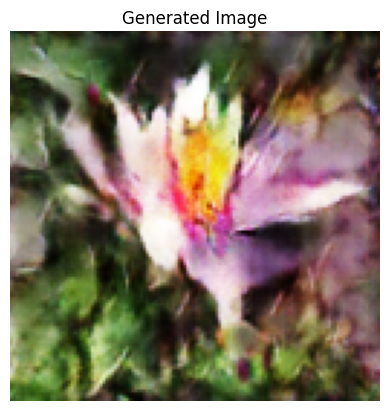

In [9]:
from PIL import Image
import matplotlib.pyplot as plt

# Load image
img = Image.open("generated_image.png")

# Display image using matplotlib
plt.imshow(img)
plt.axis('off')
plt.title("Generated Image")
plt.show()
